# Citi Bike Data
##### Ben Wilson #####

We are going to look at NYC bike sharing data to see if we can find any interesting behavior. This will also introduce a new way to download data with Python and sharpen my skills with a SQLite database

First, let's define what we are looking for... an activity level. Our activity level is calculated by adding the number of rentals and number of returns during a given hour. We will be checking this activity by the minute.

Now, let's grab the data.

In [1]:
import requests

r = requests.get('http://www.citibikenyc.com/stations/json')

In [2]:
r.json().keys()

[u'executionTime', u'stationBeanList']

In [6]:
r.json()['stationBeanList'][0:2]

[{u'altitude': u'',
  u'availableBikes': 2,
  u'availableDocks': 37,
  u'city': u'',
  u'id': 72,
  u'landMark': u'',
  u'lastCommunicationTime': u'2016-07-12 02:54:14 PM',
  u'latitude': 40.76727216,
  u'location': u'',
  u'longitude': -73.99392888,
  u'postalCode': u'',
  u'stAddress1': u'W 52 St & 11 Ave',
  u'stAddress2': u'',
  u'stationName': u'W 52 St & 11 Ave',
  u'statusKey': 1,
  u'statusValue': u'In Service',
  u'testStation': False,
  u'totalDocks': 39},
 {u'altitude': u'',
  u'availableBikes': 24,
  u'availableDocks': 7,
  u'city': u'',
  u'id': 79,
  u'landMark': u'',
  u'lastCommunicationTime': u'2016-07-12 02:56:03 PM',
  u'latitude': 40.71911552,
  u'location': u'',
  u'longitude': -74.00666661,
  u'postalCode': u'',
  u'stAddress1': u'Franklin St & W Broadway',
  u'stAddress2': u'',
  u'stationName': u'Franklin St & W Broadway',
  u'statusKey': 1,
  u'statusValue': u'In Service',
  u'testStation': False,
  u'totalDocks': 33}]

In [7]:
# Station count
len(r.json()['stationBeanList'])

509

In [8]:
# Get the unique column names from the JSON
key_list = []
for station in r.json()['stationBeanList']:
    for k in station.keys():
        if k not in key_list:
            key_list.append(k)
            
key_list

[u'availableDocks',
 u'totalDocks',
 u'city',
 u'altitude',
 u'stAddress2',
 u'longitude',
 u'lastCommunicationTime',
 u'postalCode',
 u'statusValue',
 u'testStation',
 u'stAddress1',
 u'stationName',
 u'landMark',
 u'latitude',
 u'statusKey',
 u'availableBikes',
 u'id',
 u'location']

In [9]:
# We are now ready to pull it into a Pandas DataFrame

from pandas.io.json import json_normalize

df = json_normalize(r.json()['stationBeanList'])
df.head()

,altitude,availableBikes,availableDocks,city,id,landMark,lastCommunicationTime,latitude,location,longitude,postalCode,stAddress1,stAddress2,stationName,statusKey,statusValue,testStation,totalDocks
0,,2,37,,72,,2016-07-12 02:54:14 PM,40.767272,,-73.993929,,W 52 St & 11 Ave,,W 52 St & 11 Ave,1,In Service,False,39
1,,24,7,,79,,2016-07-12 02:56:03 PM,40.719116,,-74.006667,,Franklin St & W Broadway,,Franklin St & W Broadway,1,In Service,False,33
2,,12,14,,82,,2016-07-12 02:55:37 PM,40.711174,,-74.000165,,St James Pl & Pearl St,,St James Pl & Pearl St,1,In Service,False,27
3,,31,30,,83,,2016-07-12 02:56:09 PM,40.683826,,-73.976323,,Atlantic Ave & Fort Greene Pl,,Atlantic Ave & Fort Greene Pl,1,In Service,False,62
4,,10,29,,116,,2016-07-12 02:55:50 PM,40.741776,,-74.001497,,W 17 St & 8 Ave,,W 17 St & 8 Ave,1,In Service,False,39


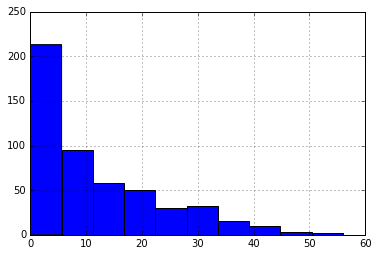

In [10]:
# lets make a couple graphs to look at  the range of values for each attribute

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

# number of bikes available
df['availableBikes'].hist()
plt.show()

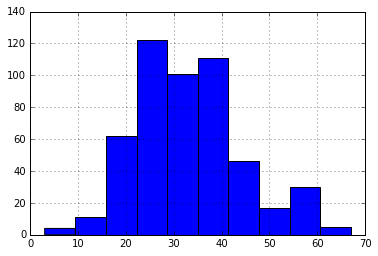

In [11]:
# number of docks at stations
df['totalDocks'].hist()
plt.show()

In [12]:
# stations in service
inService = df[df['statusValue'] == 'In Service']
len(inService)

503

In [13]:
# stations not in service
notInService = df[df['statusValue'] == 'Not In Service']
len(notInService)

6

In [14]:
# test stations
testStations = len(filter(lambda x: x == True, df['testStation']))
testStations

0

In [15]:
print df['availableBikes'].mean()
print inService['availableBikes'].mean()

print df['availableBikes'].median()
print inService['availableBikes'].median()

11.7387033399
11.8767395626
8.0
8.0


__On to lesson 4 of the Citi Bike analysis challenge__

We are going to create a database for the bike data and write a script to populate that database with the latest bike data for an hour.

In [16]:
import sqlite3 as lite

con = lite.connect('citi_bike.db')
cur = con.cursor()

with con:
    cur.execute('CREATE TABLE citibike_reference (' \
                'id INT PRIMARY KEY,'
                'totalDocks INT,' \
                'city TEXT,' \
                'altitude INT,' \
                'stAddress2 TEXT,' \
                'longitude NUMERIC,' \
                'postalCode TEXT,' \
                'testStation TEXT,' \
                'stAddress1 TEXT,' \
                'stationName TEXT,' \
                'landMark TEXT,' \
                'latitude NUMERIC, location TEXT' \
            ')')

In [17]:
# now that the reference table is created
# we are ready to populate it!

sql = 'INSERT INTO citibike_reference ' \
      '(id, totalDocks, city, altitude, stAddress2, longitude, postalCode, testStation, stAddress1,' \
      'stationName, landMark, latitude, location) ' \
      ' VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?)'
    
with con:
    for station in r.json()['stationBeanList']:
        cur.execute(sql, (station['id'],
                          station['totalDocks'],
                          station['city'],
                          station['altitude'],
                          station['stAddress2'],
                          station['longitude'],
                          station['postalCode'],
                          station['testStation'],
                          station['stAddress1'],
                          station['stationName'],
                          station['landMark'],
                          station['latitude'],
                          station['location'])
                   )

In [18]:
# extract the column from the DataFrame and put them into a list
station_ids = df['id'].tolist()

# add the '_' to the station name and also add the data type for SQLite
station_ids = ['_' + str(x) + ' INT' for x in station_ids]

# create the table
# in this case we are concatenation the string and joining all the station ids (now with an underscore and INT added)
with con:
    cur.execute("CREATE TABLE available_bikes ( execution_time INT, " + ", ".join(station_ids) + ");")

In [20]:
import time
from dateutil.parser import parse
import collections

exec_time = parse(r.json()['executionTime'])

with con:
    cur.execute('INSERT INTO available_bikes (execution_time) VALUES (?)', (exec_time.strftime('%S'),))

In [22]:
id_bikes = collections.defaultdict(int)

for station in r.json()['stationBeanList']:
    id_bikes[station['id']] = station['availableBikes']
    
with con:
    for k, v in id_bikes.iteritems():
        # does Windows really have a different EPOCH time?
        cur.execute("UPDATE available_bikes SET _" + str(k) + " = " + str(v) + " " \
                    "WHERE execution_time = " + exec_time.strftime('%S') + ";")

I ran a script in the background to pull this data in over an hour _import_citibike_data.py_ 

Now we are ready for the analysis

In [41]:
import pandas as pd
import sqlite3 as lite

con = lite.connect('citi_bike.db')
cur = con.cursor()

# looks like that even with the sleep the script made multiple requests in one minute...
df = pd.read_sql_query("SELECT * FROM available_bikes ORDER BY execution_time", con, index_col="execution_time")
df[0:4]

,_72,_79,_82,_83,_116,_119,_120,_127,_128,_137,...,_3246,_3249,_3254,_3255,_3256,_3259,_3260,_3263,_3264,_3265
execution_time,,,,,,,,,,,,,,,,,,,,,
3,4,25,12,31,12,13,0,15,24,39,...,24,15,13,13,19,6,21,27,28,6
4,2,25,10,31,10,13,0,13,22,39,...,24,15,13,15,19,8,20,30,28,7
4,2,25,10,31,10,13,0,13,22,39,...,24,15,13,15,19,8,20,30,28,7
5,3,25,10,31,10,13,0,13,25,39,...,23,15,13,14,20,8,22,30,28,7


### __Algorithm Time__

Let's write out what we want to do in psuedocode

__Goal:__ Collect and store the change of each station 

__1__ Initialize a dictionary to store the hourly differences
__2__ Loop over each station, meaning loop over the columns 
__3__ Inside the loop create a list or vector of all the available bikes at that minute
__4__ Calculate the change by taking the absolute value of the current stations available bikes at that minute minus the bikes available the next minute and add it to the overall total
__5__ Set that overall total in the hourly difference dictionary and increment to the next station

In [42]:
hour_change = collections.defaultdict(int) # step 1

for col in df.columns: # step 2
    station_vals = df[col].tolist() # step 3
    station_id = col[1:] # trims the "_" from the start of the station id
    station_change = 0 # step 4 start
    for k, v in enumerate(station_vals):
        if k < len(station_vals) - 1:
            station_change += abs(station_vals[k] - station_vals[k+1]) # step 4 end
    hour_change[int(station_id)] = station_change # step 5

In [43]:
# let's find our winner!
def keywithmaxval(d):
    return max(d, key=lambda k: d[k])

max_station = keywithmaxval(hour_change)
max_station

477

477 does not mean mush to me... let's look up more about it!

In [48]:
import datetime

# we will have to query the reference information
cur.execute("SELECT id, stationname, latitude, longitude FROM citibike_reference WHERE id = ?", (max_station,))
data = cur.fetchone()
print("The most active station is id %s at %s latitude: %s longitude: %s" % data)
print("With %d bicycles coming and going in the hour between %s and %s" % (
    hour_change[max_station],
    datetime.datetime.fromtimestamp(int(df.index[0])).strftime('%Y-%m-%d %H:%M:%S'),
    datetime.datetime.fromtimestamp(int(df.index[-1])).strftime('%Y-%m-%d %H:%M:%S')
))

The most active station is id 477 at W 41 St & 8 Ave latitude: 40.75640548 longitude: -73.9900262
With 302 bicycles coming and going in the hour between 1969-12-31 19:00:03 and 1969-12-31 19:00:58


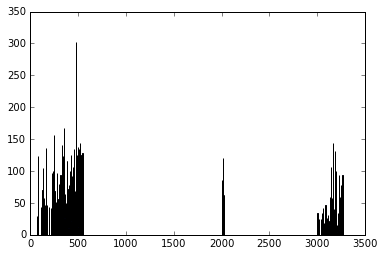

In [49]:
import matplotlib.pyplot as plf

plt.bar(hour_change.keys(), hour_change.values())
plt.show()